In [158]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [193]:
def datagen(tasks, sampl):
    x = tf.random.uniform([tasks, sampl, 1], -1.0, 1.0)
    y = tf.sin(x * tf.random.uniform([tasks, 1, 1], 0.0, 8.0) + tf.random.uniform([tasks, 1, 1], 0.0, 3.0)) * tf.random.uniform([tasks, 1, 1], 0.1, 5.0)
    l = y[:, -1:, :]
    y = tf.concat([y[:, :-1, :], tf.zeros([tasks, 1, 1])], axis=1)
    label_indicator = tf.concat([tf.ones([tasks, sampl-1, 1]), tf.zeros([tasks, 1, 1])], axis=1)
    return tf.concat([x, label_indicator, y], axis=2), l

def datagen_constant(tasks, sampl):
    x = tf.random.normal([tasks, sampl, 1])
    y = x * tf.random.uniform([tasks, 1, 1], 0.1, .5)
    l = y[:, -1:, :]
    y = tf.concat([y[:, :-1, :], tf.zeros([tasks, 1, 1])], axis=1)
    label_indicator = tf.concat([tf.ones([tasks, sampl-1, 1]), tf.zeros([tasks, 1, 1])], axis=1)
    return tf.concat([x, label_indicator, y], axis=2), l


By default, all Transformers have a key, value, and query size of 32, 8 heads, and 4 layers, and model size of NM = 256. The model size defines the dimensionality of each token, and the MLP between layers scales this size up to a hidden representation of 4 × NM where NM corresponds to the model size.

In [160]:
class BaseAttention(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = layers.MultiHeadAttention(**kwargs)
    self.layernorm = layers.LayerNormalization()
    self.add = layers.Add()

class GSA(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(layers.Layer):
  def __init__(self, d_model, dff):
    super().__init__()
    self.seq = models.Sequential([
      layers.Dense(dff, activation='relu'),
      layers.Dense(d_model)
    ])
    self.add = layers.Add()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return x

class TransformLayer(layers.Layer):
  def __init__(self,*, d_model, num_heads, dff):
    super().__init__()

    self.self_attention = GSA(
        num_heads=num_heads,
        key_dim=d_model)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Transformer(models.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff):
    super().__init__()
    self.embedder = layers.Dense(d_model)
    self.layerstack = [TransformLayer(d_model=d_model, num_heads=num_heads, dff=dff) for _ in range(num_layers)]

  def call(self, x):
    x = self.embedder(x)
    for i in range(3):
      for layer in self.layerstack:
        x = layer(x)
    return x[:, -1:, -1]


In [161]:
sampl = 100

mdim = 16
head = 2
mlay = 8
assert mdim % head == 0



(400, 100, 3) (400, 1, 1)
(100, 100, 3) (100, 1, 1)
82


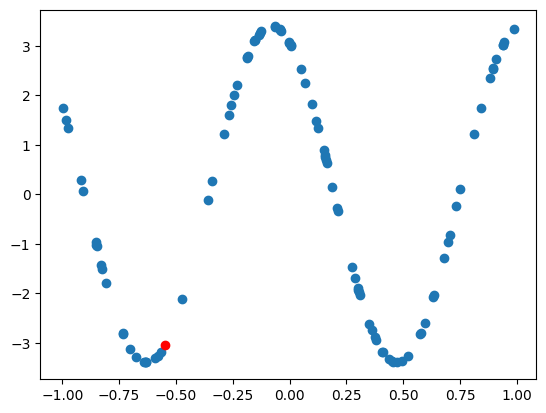

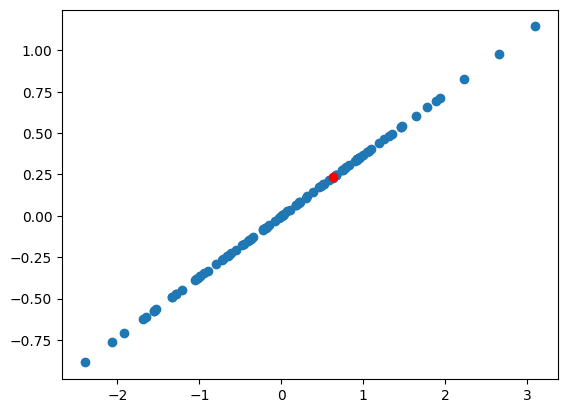

In [178]:
train_s, train_l = datagen(400, sampl)
valid_s, valid_l = datagen_constant(100, sampl)
print(train_s.shape, train_l.shape)
print(valid_s.shape, valid_l.shape)

random_sample_number = np.random.randint(0, 99) 
print(random_sample_number)

# plot data points, no lines
plt.plot(train_s[random_sample_number, :-1, 0], train_s[random_sample_number, :-1, -1], 'o')
# plot the last 1 points as red points

plt.plot(train_s[random_sample_number, -1:, 0], train_l[random_sample_number], 'ro')
plt.show()

plt.plot(valid_s[random_sample_number, :-1, 0], valid_s[random_sample_number, :-1, -1], 'o')
# plot the last 1 points as red points
plt.plot(valid_s[random_sample_number, -1:, 0], valid_l[random_sample_number], 'ro')
plt.show()


In [116]:

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [117]:

gpicl = Transformer(num_layers=mlay, d_model=mdim, num_heads=head, dff=mdim*4)


In [183]:

class DisplayProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}/{}'.format(epoch + 1, eps), end='\r')

def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


opt = optimizers.SGD(learning_rate=0.01)
gpicl.compile(optimizer=opt, loss=loss_fn, metrics=['mae'])

eps = 500

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

#with tf.device('/cpu:0'):
gpicl.fit(train_s, train_l, epochs=eps, batch_size=200, validation_data=(valid_s, valid_l), callbacks=[tensorboard_callback, DisplayProgress()], 
#verbose=0
)
    

Epoch 1/500


2023-03-31 11:50:09.454720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 1.8621 - mae: 0.9646

2023-03-31 11:50:14.423947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 8s 2s/step - loss: 1.8621 - mae: 0.9646 - val_loss: 0.3385 - val_mae: 0.5073
Epoch 2/500
2/2 [==============================] - 2s 1s/step - loss: 2.4482 - mae: 1.1363 - val_loss: 0.3989 - val_mae: 0.5903
Epoch 3/500
2/2 [==============================] - 2s 1s/step - loss: 2.9371 - mae: 1.2463 - val_loss: 0.2445 - val_mae: 0.4257
Epoch 4/500
2/2 [==============================] - 2s 931ms/step - loss: 2.2745 - mae: 0.9804 - val_loss: 0.7135 - val_mae: 0.6477
Epoch 5/500
2/2 [==============================] - 2s 929ms/step - loss: 2.8303 - mae: 1.2484 - val_loss: 0.2883 - val_mae: 0.4459
Epoch 6/500
2/2 [==============================] - 2s 912ms/step - loss: 1.9818 - mae: 0.9997 - val_loss: 0.3598 - val_mae: 0.4778
Epoch 7/500
2/2 [==============================] - 2s 917ms/step - loss: 1.8789 - mae: 0.9697 - val_loss: 0.3805 - val_mae: 0.5367
Epoch 8/500
2/2 [==============================] - 2s 913ms/step - loss: 1.6971 - mae: 0.9126 - val_loss

loss & MAE [0.0754275694489479, 0.20824034512043]
0.05643733
1.9868584
-0.059952535
0.3786287
1/1 [==============================] - 0s 166ms/step
[-3.186183]
1/1 [==============================] - 0s 178ms/step


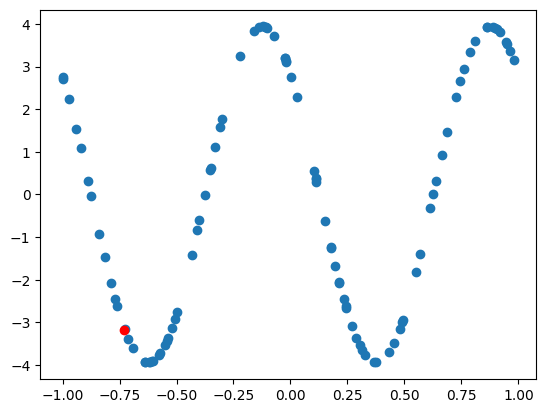

1/1 [==============================] - 0s 326ms/step


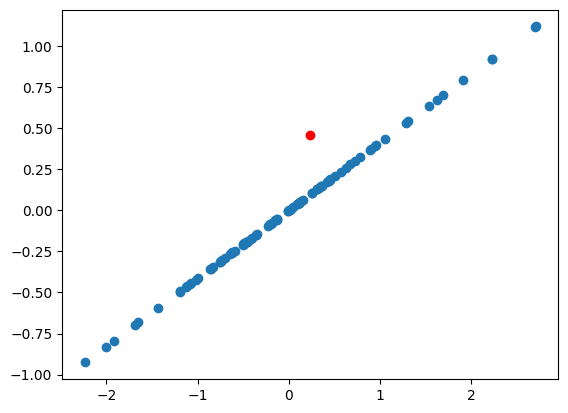

In [194]:
test_s, test_l = datagen(400, sampl)

# get loss on test set
print('loss & MAE', gpicl.evaluate(test_s, test_l, verbose=0))

print(tf.math.reduce_mean(test_l).numpy())
print(tf.math.reduce_std(test_l).numpy())
print(tf.math.reduce_mean(valid_l).numpy())
print(tf.math.reduce_std(valid_l).numpy())

num = np.random.randint(0, 99) 
# plot data points, no lines
plt.plot(test_s[num, :-1, 0], test_s[num, :-1, -1], 'o')
# plot the last 10 points as red points

print(gpicl.predict(test_s[num:num+1, :, :])[0])
plt.plot(test_s[num, -1:, 0], gpicl.predict(test_s[num:num+1, :, :])[0], 'ro')
plt.show()

plt.plot(valid_s[num, :-1, 0], valid_s[num, :-1, -1], 'o')
# plot the last 10 points as red points
plt.plot(valid_s[num, -1:, 0], gpicl.predict(valid_s[num:num+1, :, :])[0], 'ro')
plt.show()

In [189]:
%tensorboard --logdir logs/fit